Examination of what song patterns precede female stopping

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d as smooth
from scipy import signal, stats

from disp import set_font_size, set_plot, set_color, plot_b

cc = np.concatenate

DATA_FILE = 'data/simple/c_song_f_behav.csv'
NTR = 276
FPS = 30.03
DT = 1/FPS

In [2]:
df_all = pd.read_csv(DATA_FILE)
df_trs = [df_all[df_all['ID'] == ctr] for ctr in range(NTR)]
tr_lens = [len(df_tr) for df_tr in df_trs]

# smooth ffv
for df_tr in df_trs:
    df_tr['FFV'] = smooth(df_tr['FFV'], .5*FPS)

/Users/rp21/opt/miniconda3/envs/sci/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [3]:
# estimate max ffv for each fly
max_ffvs = []
for df_tr in df_trs:
    tr_len = len(df_tr)
    max_ffv = np.median(np.sort(df_tr['FFV'])[-int(round(.2*tr_len)):])
    max_ffvs.append(max_ffv)
    
# identify slowing/stopping points
## look for all events where ffv crosses 50% mark
## conditioning on fact that ffv in 1-sec wdw surrounding timepoint dropped more than 50% of max ffv
idn_crosses_all = []
for df_tr, max_ffv in zip(df_trs, max_ffvs):
    # find all downward crossings of half max FFV
    ffv = np.array(df_tr['FFV'])
    mask = ffv > (max_ffv/2)
    diff = np.diff(cc([[0], mask])).astype(float)
    idn_crosses = np.nonzero(diff < 0)[0]
    drops = np.nan*np.zeros(idn_crosses.shape)
    for cidn_cross, idn_cross in enumerate(idn_crosses):
        pre_max = np.max(ffv[max(0, idn_cross-int(round(.5/DT))):idn_cross])
        pre_min = np.min(ffv[idn_cross:idn_cross+int(round(.5/DT))])
        drops[cidn_cross] = (pre_min - pre_max)/max_ffv
    idn_crosses_all.append(idn_crosses[drops < -.4])

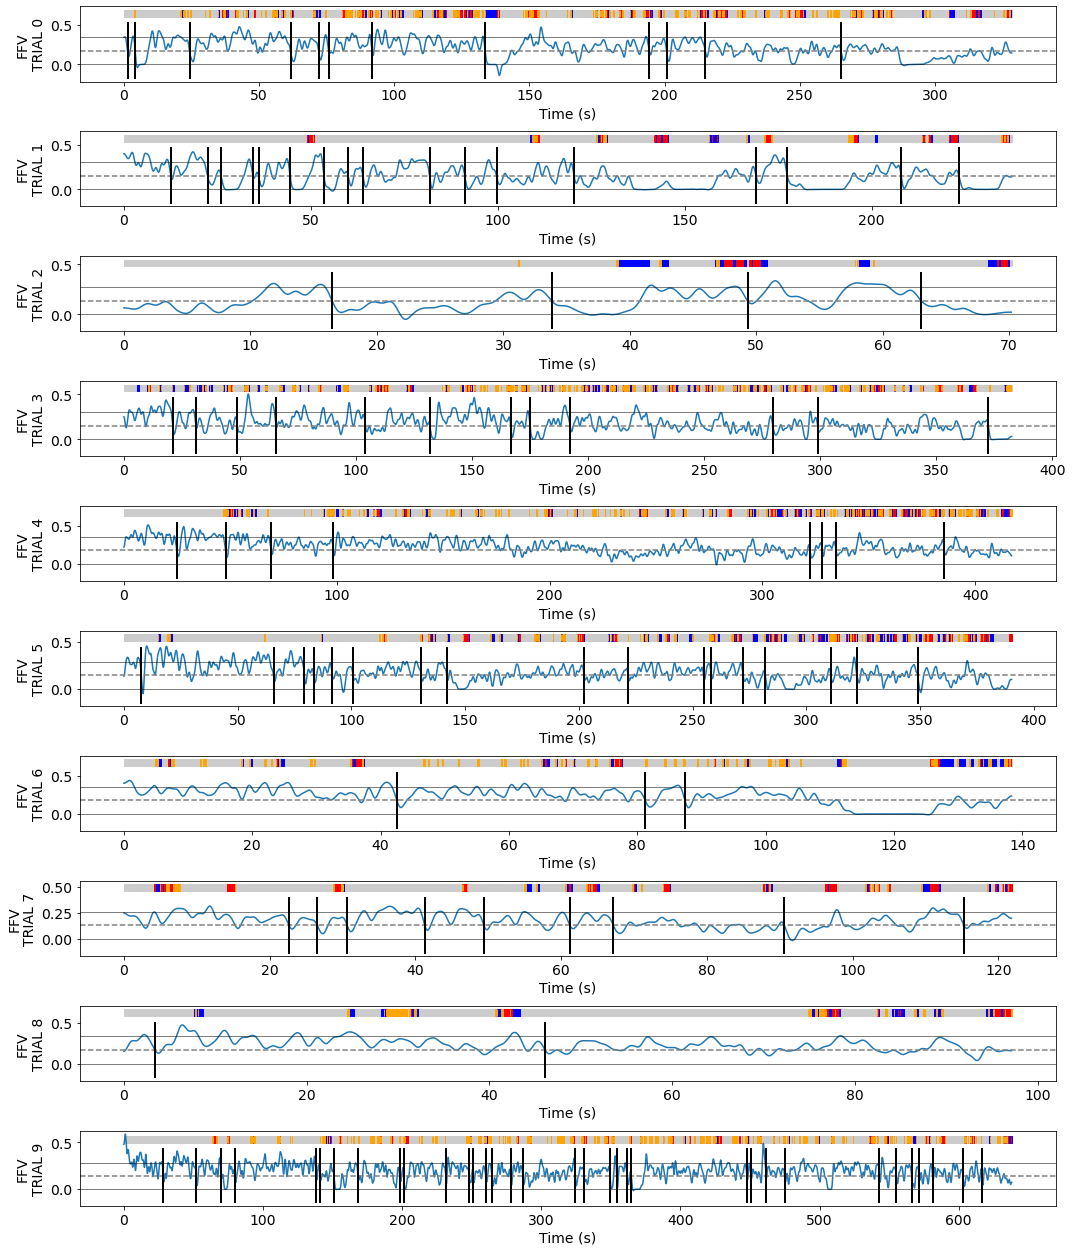

In [24]:
NXPL = 10

fig, axs = plt.subplots(NXPL, 1, figsize=(15, NXPL*1.75), tight_layout=True)

for ctr, (df_tr, max_ffv, idn_crosses, ax) in enumerate(zip(df_trs, max_ffvs, idn_crosses_all, axs)):
    ax.plot(df_tr['T'], df_tr['FFV'])
    song = np.zeros(len(df_tr))
    song[df_tr['S'] == 1] = 1
    song[df_tr['P'] == 1] = 2
    song[df_tr['F'] == 1] = 3
    
    plot_b(ax, df_tr['T'], song, extent=[0, DT*len(df_tr), 1.75*max_ffv, 2*max_ffv], c=[(.8, .8, .8), 'b', 'r', 'orange'])
    ax.axhline(0, color='k', lw=.5)
    ax.axhline(max_ffv, color='k', lw=.5)
    ax.axhline(max_ffv/2, color='gray', ls='--')
    for idn_cross in idn_crosses:
        ax.plot(2*[DT*idn_cross], [-.5*max_ffv, 1.5*max_ffv], c='k', lw=2)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(f'FFV\nTRIAL {ctr}')
    
    set_font_size(ax, 14)

In [5]:
# collect song preceding slowing points
WDW = 6
IWDW = int(round(WDW/DT))
t = np.arange(IWDW)*DT

song_snippets = [[] for _ in range(NTR)]
song_snippets_ctl = [[] for _ in range(NTR)]

for ctr, (df_tr, idn_crosses) in enumerate(zip(df_trs, idn_crosses_all)):
    s = np.zeros(len(df_tr), dtype=int)
    s[df_tr['S']==1] = 1
    s[df_tr['P']==1] = 2
    s[df_tr['F']==1] = 3
    
    for idn_cross in idn_crosses:
        if idn_cross >= IWDW:
            song_snippets[ctr].append(s[idn_cross-IWDW:idn_cross])
    
    for idn_cross in np.random.randint(IWDW, len(df_tr), len(song_snippets[ctr])):
        song_snippets_ctl[ctr].append(s[idn_cross-IWDW:idn_cross])
        
song_snippets = cc([np.array(song_snippets_) for song_snippets_ in song_snippets], axis=0)
song_snippets_ctl = cc([np.array(song_snippets_) for song_snippets_ in song_snippets_ctl], axis=0)

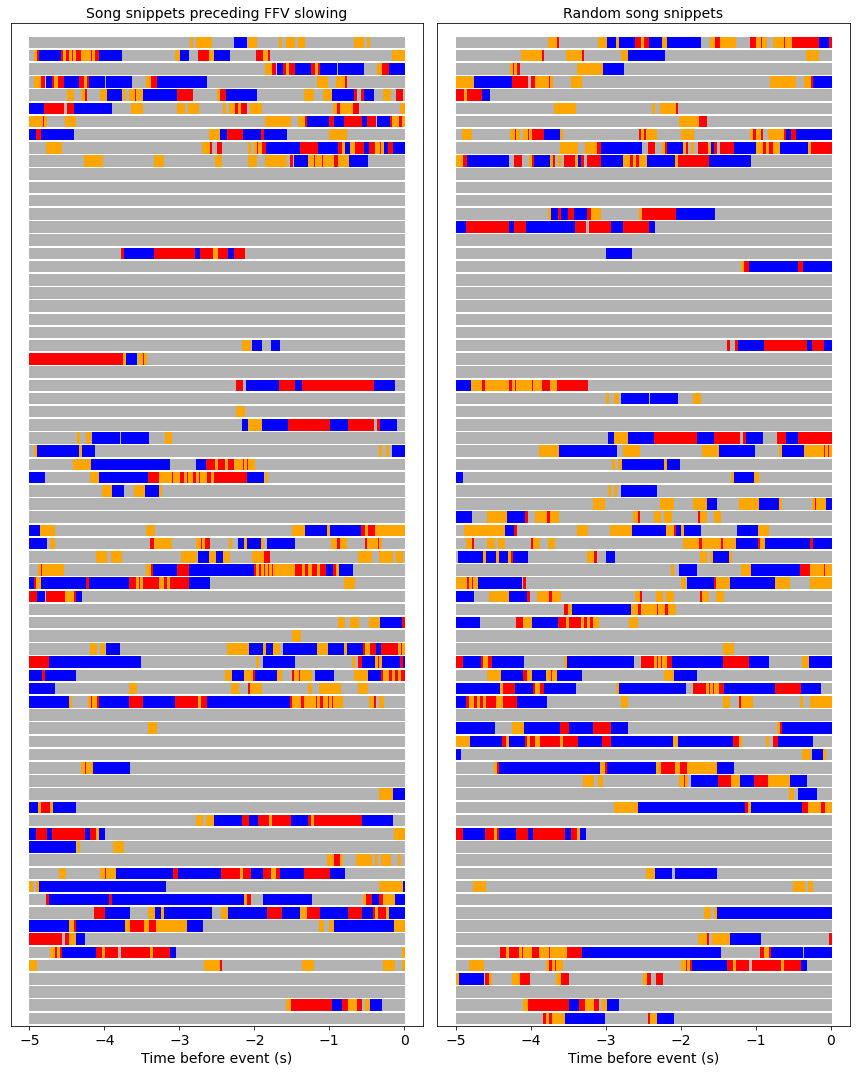

In [28]:
NSTOP = 75
fig, axs = plt.subplots(1, 2, figsize=(12, NSTOP/5), tight_layout=True)

for ssctr, song_snippet in enumerate(song_snippets[:NSTOP]):
    plot_b(axs[0], t, song_snippet, extent=[-5, 0, -ssctr, -ssctr-.8], c=[(.7, .7, .7), 'b', 'r', 'orange'])
axs[0].set_title('Song snippets preceding FFV slowing')
    
for ssctr, song_snippet in enumerate(song_snippets_ctl[:NSTOP]):
    plot_b(axs[1], t, song_snippet, extent=[-5, 0, -ssctr, -ssctr-.8], c=[(.7, .7, .7), 'b', 'r', 'orange'])
axs[1].set_title('Random song snippets')

for ax in axs:
    ax.set_ylim(-NSTOP, 1)
    ax.yaxis.set_visible(False)
    ax.set_xlabel('Time before event (s)')
set_font_size(axs, 14)

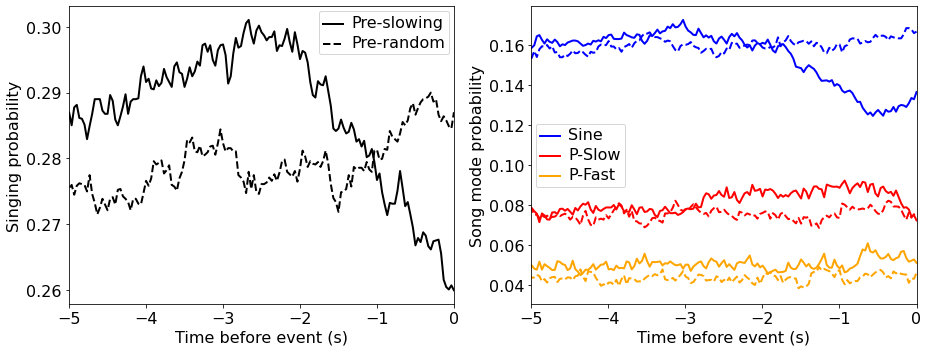

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5), tight_layout=True)

axs[0].plot(-t[::-1], np.mean(song_snippets>0, axis=0), c='k', lw=2)
axs[0].plot(-t[::-1], np.mean(song_snippets_ctl>0, axis=0), c='k', ls='--', lw=2)

axs[0].set_xlim(-5, 0)
axs[0].set_xlabel('Time before event (s)')
axs[0].set_ylabel('Singing probability')
axs[0].legend(['Pre-slowing', 'Pre-random'])

axs[1].plot(-t[::-1], np.mean(song_snippets==1, axis=0), c='b', lw=2)
axs[1].plot(-t[::-1], np.mean(song_snippets==2, axis=0), c='r', lw=2)
axs[1].plot(-t[::-1], np.mean(song_snippets==3, axis=0), c='orange', lw=2)

axs[1].plot(-t[::-1], np.mean(song_snippets_ctl==1, axis=0), c='b', ls='--', lw=2)
axs[1].plot(-t[::-1], np.mean(song_snippets_ctl==2, axis=0), c='r', ls='--', lw=2)
axs[1].plot(-t[::-1], np.mean(song_snippets_ctl==3, axis=0), c='orange', ls='--', lw=2)

axs[1].set_xlim(-5, 0)
axs[1].set_xlabel('Time before event (s)')
axs[1].set_ylabel('Song mode probability')
axs[1].legend(['Sine', 'P-Slow', 'P-Fast'])
set_font_size(axs, 16)

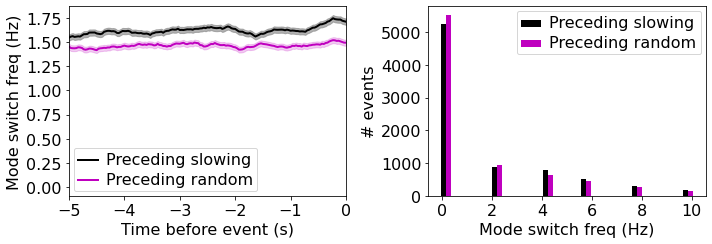

In [35]:
# compute switching freq
WDW = .5
IWDW = int(round(WDW/DT))

diff = cc([np.zeros((len(song_snippets), 1)), np.diff(song_snippets, axis=1)], axis=1)
switches = (np.abs(diff) > 0).astype(float)  # all switching events
switch_freq = signal.fftconvolve(switches, np.ones((len(switches), IWDW)), mode='full', axes=1)[:, :switches.shape[1]]/WDW

diff_ctl = cc([np.zeros((len(song_snippets_ctl), 1)), np.diff(song_snippets_ctl, axis=1)], axis=1)
switches_ctl = (np.abs(diff_ctl) > 0).astype(float)  # all switching events
switch_freq_ctl = signal.fftconvolve(switches_ctl, np.ones((len(switches_ctl), IWDW)), mode='full', axes=1)[:, :switches.shape[1]]/WDW

fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), tight_layout=True)
axs[0].plot(-t[::-1], np.nanmean(switch_freq, 0), c='k', lw=2)
axs[0].plot(-t[::-1], np.nanmean(switch_freq_ctl, 0), c='m', lw=2)

switch_freq_sem = np.nanstd(switch_freq, 0)/np.sqrt(len(switch_freq))
axs[0].fill_between(-t[::-1], np.nanmean(switch_freq, 0)-switch_freq_sem, np.nanmean(switch_freq, 0)+switch_freq_sem, color='gray', alpha=.6)

switch_freq_ctl_sem = np.nanstd(switch_freq_ctl, 0)/np.sqrt(len(switch_freq_ctl))
axs[0].fill_between(-t[::-1], np.nanmean(switch_freq_ctl, 0)-switch_freq_ctl_sem, np.nanmean(switch_freq_ctl, 0)+switch_freq_ctl_sem, color='m', alpha=.2)

axs[0].set_xlim(-5, 0)
axs[0].set_xlabel('Time before event (s)')
axs[0].set_ylabel('Mode switch freq (Hz)')

axs[0].legend(['Preceding slowing', 'Preceding random'])

axs[1].hist(
    np.transpose([switch_freq[:, -1], switch_freq_ctl[:, -1]]), bins=np.linspace(-.1, 10.1, 21), color=['k', 'm'])
axs[1].set_xlabel('Mode switch freq (Hz)')
axs[1].set_ylabel('# events')
axs[1].legend(['Preceding slowing', 'Preceding random'])
set_font_size(axs, 16)

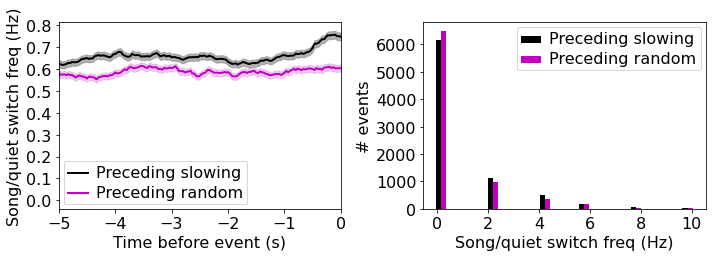

In [36]:
# compute switching freq
diff = cc([np.zeros((len(song_snippets), 1)), np.diff(song_snippets>0, axis=1)], axis=1)
switches = (np.abs(diff) > 0).astype(float)  # all switching events
switch_freq = signal.fftconvolve(switches, np.ones((len(switches), IWDW)), mode='full', axes=1)[:, :switches.shape[1]]/WDW

diff_ctl = cc([np.zeros((len(song_snippets_ctl), 1)), np.diff(song_snippets_ctl>0, axis=1)], axis=1)
switches_ctl = (np.abs(diff_ctl) > 0).astype(float)  # all switching events
switch_freq_ctl = signal.fftconvolve(switches_ctl, np.ones((len(switches_ctl), IWDW)), mode='full', axes=1)[:, :switches.shape[1]]/WDW

fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), tight_layout=True)
axs[0].plot(-t[::-1], np.nanmean(switch_freq, 0), c='k', lw=2)
axs[0].plot(-t[::-1], np.nanmean(switch_freq_ctl, 0), c='m', lw=2)

switch_freq_sem = np.nanstd(switch_freq, 0)/np.sqrt(len(switch_freq))
axs[0].fill_between(-t[::-1], np.nanmean(switch_freq, 0)-switch_freq_sem, np.nanmean(switch_freq, 0)+switch_freq_sem, color='gray', alpha=.6)

switch_freq_ctl_sem = np.nanstd(switch_freq_ctl, 0)/np.sqrt(len(switch_freq_ctl))
axs[0].fill_between(-t[::-1], np.nanmean(switch_freq_ctl, 0)-switch_freq_ctl_sem, np.nanmean(switch_freq_ctl, 0)+switch_freq_ctl_sem, color='m', alpha=.2)

axs[0].set_xlim(-5, 0)
axs[0].set_xlabel('Time before event (s)')
axs[0].set_ylabel('Song/quiet switch freq (Hz)')

axs[0].legend(['Preceding slowing', 'Preceding random'])

axs[1].hist(
    np.transpose([switch_freq[:, -1], switch_freq_ctl[:, -1]]), bins=np.linspace(-.1, 10.1, 21), color=['k', 'm'])
axs[1].set_xlabel('Song/quiet switch freq (Hz)')
axs[1].set_ylabel('# events')
axs[1].legend(['Preceding slowing', 'Preceding random'])
set_font_size(axs, 16)

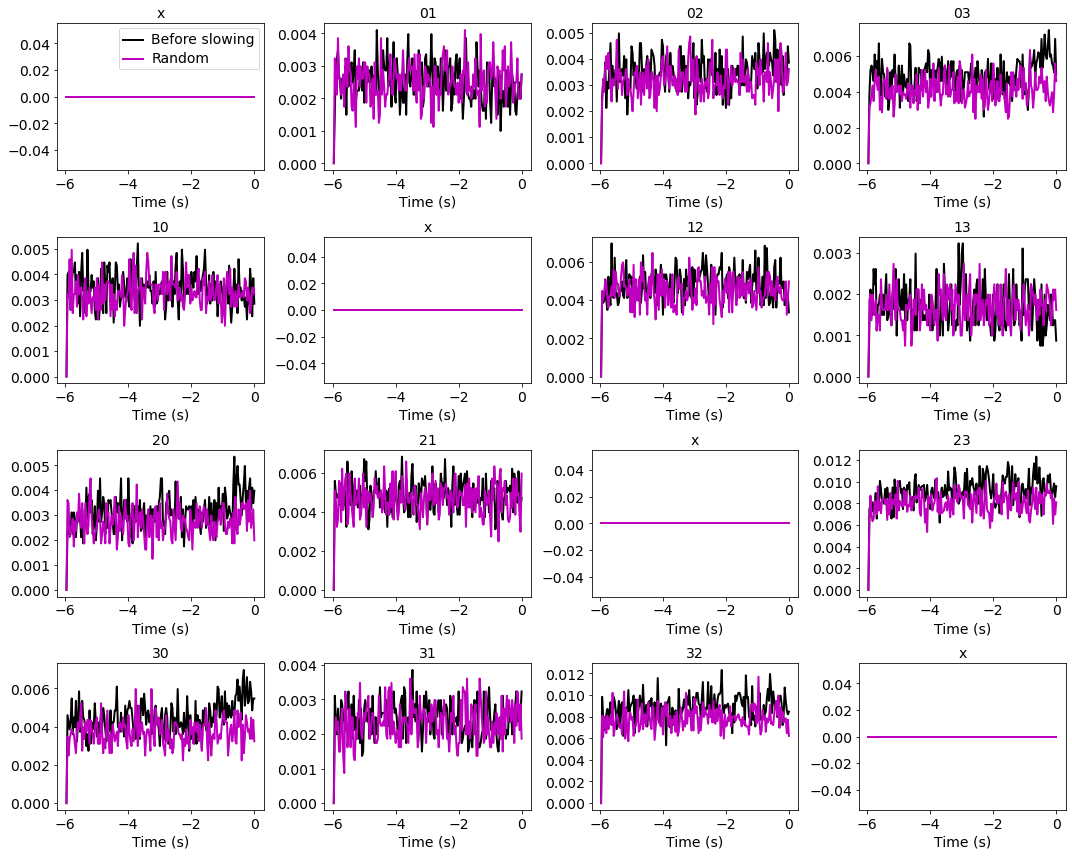

In [10]:
# identify labeled switches
def s_to_switch_labels(s):
    temp = np.array([str(a) + str(b) for a, b in zip(cc([[0], s[:-1]]), s)])
    temp[0] = ''
    return temp

switch_labels = np.array([s_to_switch_labels(song_snippet) for song_snippet in song_snippets])
switch_labels_ctl = np.array([s_to_switch_labels(song_snippet) for song_snippet in song_snippets_ctl])

fig, axs = plt.subplots(4, 4, figsize=(15, 12), tight_layout=True)
labels = ['x', '01', '02', '03', '10', 'x', '12', '13', '20', '21', 'x', '23', '30', '31', '32' ,'x']

for ax, label in zip(axs.flatten(), labels):
    ax.plot(-t[::-1], np.mean(switch_labels == label, axis=0), c='k', lw=2)
    ax.plot(-t[::-1], np.mean(switch_labels_ctl == label, axis=0), c='m', lw=2)
    
    ax.set_xlabel('Time (s)')
    ax.set_title(label)
    
axs[0, 0].legend(['Before slowing', 'Random'])
set_font_size(axs, 14)

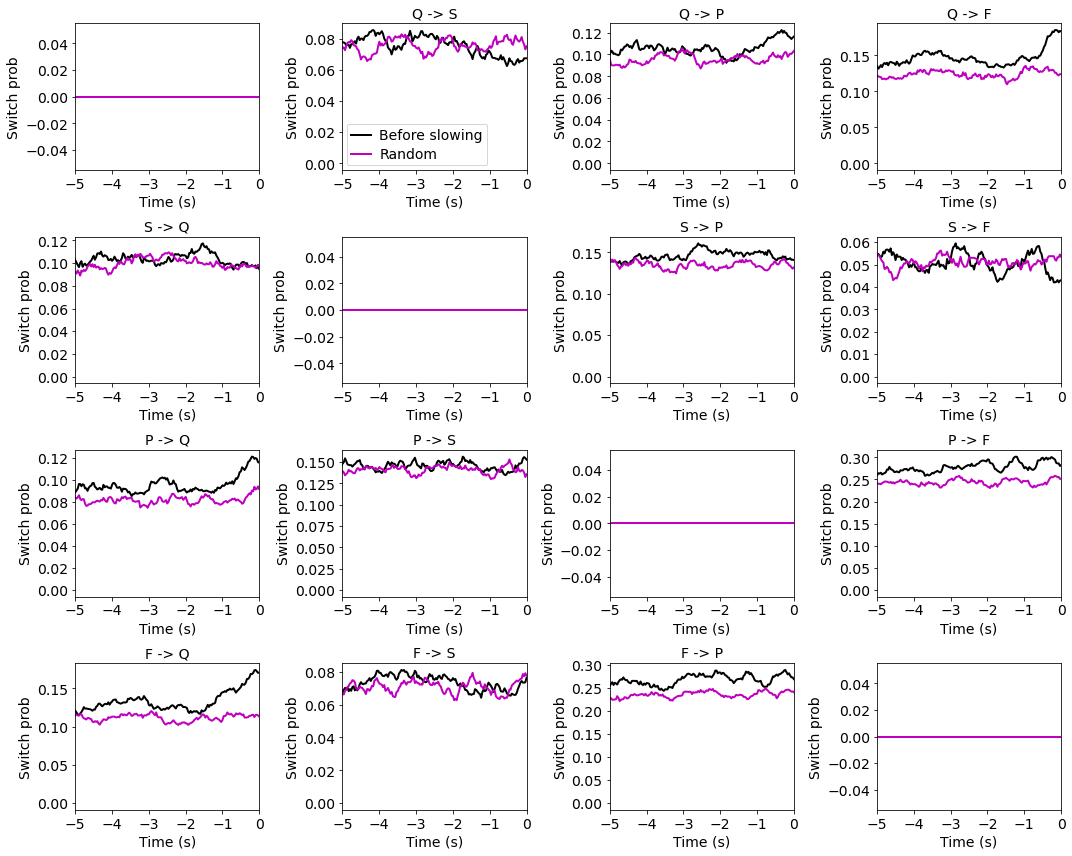

In [11]:
fig, axs = plt.subplots(4, 4, figsize=(15, 12), tight_layout=True)
labels = ['x', '01', '02', '03', '10', 'x', '12', '13', '20', '21', 'x', '23', '30', '31', '32' ,'x']
mode_dict = {'0': 'Q', '1': 'S', '2': 'P', '3': 'F'}

for ax, label in zip(axs.flatten(), labels):
    switch_freq = signal.fftconvolve(switch_labels==label, np.ones((len(switch_labels), IWDW))/IWDW, mode='full', axes=1)[:, :switch_labels.shape[1]]/DT
    ax.plot(-t[::-1], np.nanmean(switch_freq, 0), c='k', lw=2)
    
    switch_freq_ctl = signal.fftconvolve(switch_labels_ctl==label, np.ones((len(switch_labels), IWDW))/IWDW, mode='full', axes=1)[:, :switch_labels.shape[1]]/DT
    ax.plot(-t[::-1], np.nanmean(switch_freq_ctl, 0), c='m', lw=2)
    
    ax.set_xlim(-5, 0)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Switch prob')
    if label != 'x':
        ax.set_title(f'{mode_dict[label[0]]} -> {mode_dict[label[1]]}')
    
axs[0, 1].legend(['Before slowing', 'Random'])
set_font_size(axs, 14)

In [12]:
from aux import get_seg

s_durs = []
s_durs_ctl = []
p_durs = []
p_durs_ctl = []
f_durs = []
f_durs_ctl = []
b_durs = []
b_durs_ctl = []

for song_snippet in song_snippets:
    
    if 1 in song_snippet:
        s_bds = get_seg(song_snippet==1, min_gap=1)[1]
        s_durs.append(DT*(s_bds[:, 1] - s_bds[:, 0]))
    if 2 in song_snippet:
        p_bds = get_seg(song_snippet==2, min_gap=1)[1]
        p_durs.append(DT*(p_bds[:, 1] - p_bds[:, 0]))
    if 3 in song_snippet:
        f_bds = get_seg(song_snippet==3, min_gap=1)[1]
        f_durs.append(DT*(f_bds[:, 1] - f_bds[:, 0]))
    if (1 in song_snippet) or (2 in song_snippet) or (3 in song_snippet):
        b_bds = get_seg(song_snippet>0, min_gap=1)[1]
        b_durs.append(DT*(b_bds[:, 1] - b_bds[:, 0]))
        
for song_snippet in song_snippets_ctl:
    
    if 1 in song_snippet:
        s_bds = get_seg(song_snippet==1, min_gap=1)[1]
        s_durs_ctl.append(DT*(s_bds[:, 1] - s_bds[:, 0]))
    if 2 in song_snippet:
        p_bds = get_seg(song_snippet==2, min_gap=1)[1]
        p_durs_ctl.append(DT*(p_bds[:, 1] - p_bds[:, 0]))
    if 3 in song_snippet:
        f_bds = get_seg(song_snippet==3, min_gap=1)[1]
        f_durs_ctl.append(DT*(f_bds[:, 1] - f_bds[:, 0]))
    if (1 in song_snippet) or (2 in song_snippet) or (3 in song_snippet):
        b_bds = get_seg(song_snippet>0, min_gap=1)[1]
        b_durs_ctl.append(DT*(b_bds[:, 1] - b_bds[:, 0]))

/Users/rp21/opt/miniconda3/envs/sci/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


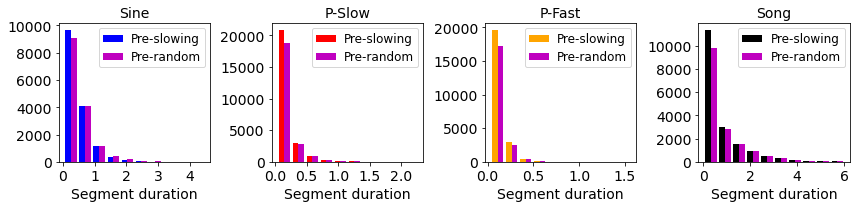

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
axs[0].hist(np.transpose([cc(s_durs), cc(s_durs_ctl)]), color=['b', 'm'])
axs[1].hist(np.transpose([cc(p_durs), cc(p_durs_ctl)]), color=['r', 'm'])
axs[2].hist(np.transpose([cc(f_durs), cc(f_durs_ctl)]), color=['orange', 'm'])
axs[3].hist(np.transpose([cc(b_durs), cc(b_durs_ctl)]), color=['k', 'm'])

for ax, label in zip(axs, ['Sine', 'P-Slow', 'P-Fast', 'Song']):
    ax.set_xlabel('Segment duration')
    ax.set_title(label)
    ax.legend(['Pre-slowing', 'Pre-random'])


set_font_size(axs, 14, legend_font_size=12)